In [124]:
import pandas as pd

In [125]:
# 检查数据
def check_data(data):
    print("数据的前几行：")
    display(data.head())
    print("\n数据的信息：")
    data.info()
    print("\n数据是否有缺失值：")
    print(data.isnull().sum())
    print("\n数据的描述统计信息：")
    display(data.describe())

file_path = './data/SMCI.csv'
data = pd.read_csv(file_path)
check_data(data)

数据的前几行：


,Date,Close/Last,Volume,Open,High,Low
0,06/21/2024,$905.26,7465581,$900.10,$917.9499,$863.22
1,06/20/2024,$917.635,13432940,$961.29,$1014.02,$900.32
2,06/18/2024,$920.01,8762073,$897.00,$938.88,$883.31
3,06/17/2024,$887.41,8911764,$857.40,$921.91,$828.09
4,06/14/2024,$844.54,6598781,$846.93,$872.00,$825.61



数据的信息：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB

数据是否有缺失值：
Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

数据的描述统计信息：


,Volume
count,2.516000e+03
mean,1.053906e+06
std,2.374987e+06
min,3.038000e+03
25%,2.295038e+05
50%,3.733460e+05
75%,7.029622e+05
max,3.403834e+07


In [126]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import datetime as dt
import matplotlib.pyplot as plt

In [127]:
# 目前用的是tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [128]:
# 去除美元符号并转换为浮点数
data['Close'] = data['Close/Last'].str.replace('$', '').astype(float)

In [129]:
data

,Date,Close/Last,Volume,Open,High,Low,Close
0,06/21/2024,$905.26,7465581,$900.10,$917.9499,$863.22,905.260
1,06/20/2024,$917.635,13432940,$961.29,$1014.02,$900.32,917.635
2,06/18/2024,$920.01,8762073,$897.00,$938.88,$883.31,920.010
3,06/17/2024,$887.41,8911764,$857.40,$921.91,$828.09,887.410
4,06/14/2024,$844.54,6598781,$846.93,$872.00,$825.61,844.540
...,...,...,...,...,...,...,...
2511,06/30/2014,$25.27,648122,$24.69,$25.39,$24.61,25.270
2512,06/27/2014,$24.69,1482237,$25.24,$25.405,$24.69,24.690
2513,06/26/2014,$25.45,342669,$26.00,$26.00,$25.21,25.450
2514,06/25/2014,$25.27,491864,$25.24,$25.49,$24.57,25.270


In [130]:
# Variables
# Time horizon set to be 9 years for training, 1 year for validation

time_steps = 90     # tested [30, 60, 90, 120], 90 is the most efficient one

In [131]:
# 数据预处理
def preprocess_data(train_set, valid_set):
    scaler = MinMaxScaler(feature_range=(0, 1))
    
    # 将训练集和验证集的Close列进行归一化
    train_data = scaler.fit_transform(train_set['Close'].values.reshape(-1, 1))
    valid_data = scaler.transform(valid_set['Close'].values.reshape(-1, 1))
    
    x_train, y_train = [], []
    for i in range(time_steps, len(train_data)):
        x_train.append(train_data[i-time_steps:i, 0])
        y_train.append(train_data[i, 0])
    
    x_valid, y_valid = [], []
    for i in range(time_steps, len(valid_data)):
        x_valid.append(valid_data[i-time_steps:i, 0])
        y_valid.append(valid_data[i, 0])
    
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    
    x_valid, y_valid = np.array(x_valid), np.array(y_valid)
    x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
    
    return x_train, y_train, x_valid, y_valid, scaler

In [132]:
# 调参：LSTM模型
def build_model():
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(time_steps, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [133]:
# 调参：训练模型
def train_model(model, x_train, y_train):
    model.fit(x_train, y_train, epochs=25, batch_size=32)

In [134]:
# 预测函数
def make_prediction(model, x_valid, scaler):
    predictions = model.predict(x_valid)
    predictions = scaler.inverse_transform(predictions)
    return predictions

In [135]:
data['Date'] = pd.to_datetime(data['Date'])
train_set = data[(data['Date'] >= '2014-06-24') & (data['Date'] < '2023-06-24')].copy()
vaild_set = data[(data['Date'] >= '2023-06-25') & (data['Date'] < '2024-06-21')].copy()

In [136]:
train_set

,Date,Close/Last,Volume,Open,High,Low,Close
250,2023-06-23,$216.06,2513226,$222.34,$224.49,$214.23,216.06
251,2023-06-22,$226.46,3938637,$221.99,$241.9699,$221.14,226.46
252,2023-06-21,$219.91,2603561,$221.00,$227.00,$217.20,219.91
253,2023-06-20,$222.40,3366546,$227.30,$235.7096,$219.33,222.40
254,2023-06-16,$230.77,3034647,$245.00,$245.78,$230.37,230.77
...,...,...,...,...,...,...,...
2511,2014-06-30,$25.27,648122,$24.69,$25.39,$24.61,25.27
2512,2014-06-27,$24.69,1482237,$25.24,$25.405,$24.69,24.69
2513,2014-06-26,$25.45,342669,$26.00,$26.00,$25.21,25.45
2514,2014-06-25,$25.27,491864,$25.24,$25.49,$24.57,25.27


In [137]:
# 调用预处理
x_train, y_train, x_valid, y_valid, scaler = preprocess_data(train_set, vaild_set)
# 训练模型
model = build_model()
train_model(model, x_train, y_train)
#预测
valid_preds = make_prediction(model, x_valid, scaler)

Epoch 1/25


/Users/beilinye/Desktop/Spring_2024/SYDE_660a/6_Code/stock-prediction/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0016
Epoch 2/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 2.2726e-04
Epoch 3/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.7945e-04
Epoch 4/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.6532e-04
Epoch 5/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 1.2634e-04
Epoch 6/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.4924e-04
Epoch 7/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.2397e-04
Epoch 8/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.5162e-04
Epoch 9/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.1935e-04
Epoch 10/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 9.2759e-05
Epoch 11/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.1374e-04
Epoch 12/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 1.0851e-04
Epoch 13/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 8.7587e-05
Epoch 14/25
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 1.1148e-04
Epoch 15/25
68/68 ━━━━━━━━━━━━

In [1]:
print(valid_preds)

NameError: name 'valid_preds' is not defined

LSTM RMSE on validation set: 34.167561980339926


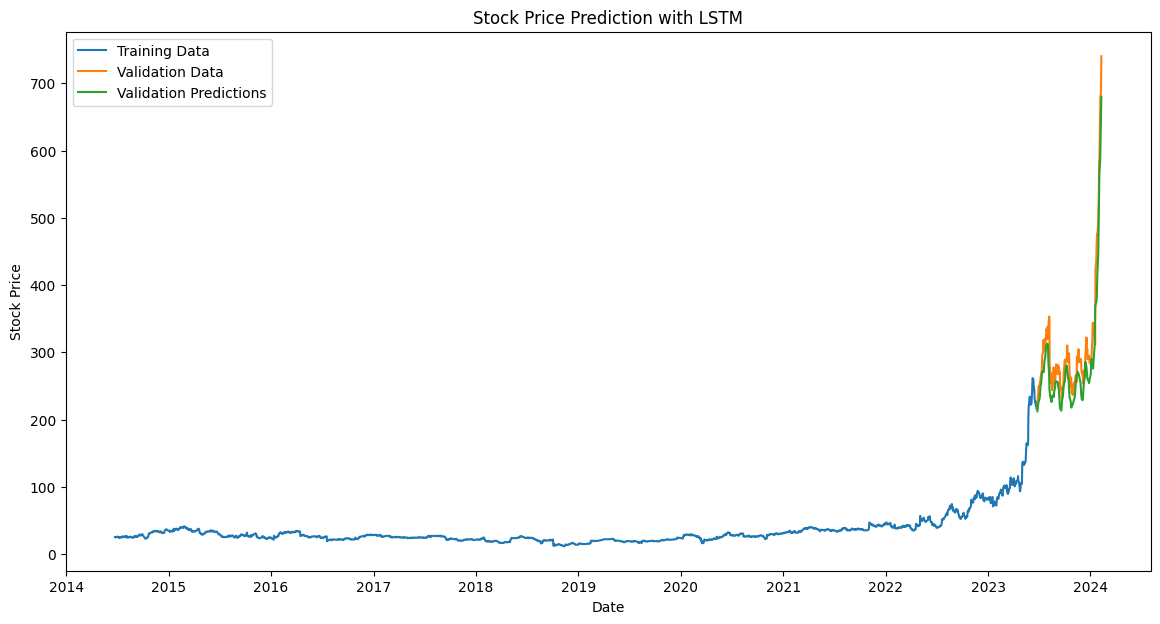

In [138]:
# 计算验证集上的RMSE -- 预测效果非常之差
valid_rmse = np.sqrt(mean_squared_error(vaild_set['Close'].values[time_steps:], valid_preds))
print(f"LSTM RMSE on validation set: {valid_rmse}")

# 可视化LSTM结果
plt.figure(figsize=(14, 7))
plt.plot(train_set['Date'], train_set['Close'], label='Training Data')
plt.plot(vaild_set['Date'][time_steps:], vaild_set['Close'].values[time_steps:], label='Validation Data')
plt.plot(vaild_set['Date'][time_steps:], valid_preds, label='Validation Predictions')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction with LSTM')
plt.legend()
plt.show()